# Coordinates to Pixels: Bounding Box

This notebook contains parts of code from Dr. Vadim Savenkov

In [1]:
import os, io, json
import pandas as pd
import geopandas as gpd
from ast import literal_eval
from shapely.geometry import shape, mapping as shapely_mapping
from shapely import wkt
import folium
from PIL import Image, ImageDraw
from __future__ import print_function
from ipywidgets import interact,interact_manual,HBox,Output,Tab
import time

import cv2
import random
import re
import sys
import multiprocessing.dummy as mp 
import numpy as np
import xml.etree.ElementTree as ET
from xml.dom import minidom

### Get unique IDs

In [2]:
def get_point(geom):
    try:
        pt = re.split(r",", geom[9:])[0]
        pt = tuple(map(float, pt.split(' ')))
        pt_s = (pt[1], pt[0])
    except:
        print(sys.exc_info())
        return np.nan
    
    return pt_s

### Load data

In [15]:
# TRUCKS
# Load filtered list
df = pd.read_csv("data/osm_data_trucks.csv", index_col=0)
PARKING_TYPE = "TRUCK"

In [16]:
# CARS
# Load filtered list
#df = pd.read_csv("data/osm_data_cars.csv", index_col=0) # evtl. osm_data_cars_f!
#PARKING_TYPE = "CAR"

In [4]:
# Define pt tuple again and set geometry
df["pt"] = df["geometry"].transform(lambda x: get_point(x))
df['geometry'] = df['geometry'].apply(wkt.loads)

# Create Geo DataFrame
real_polys = gpd.GeoDataFrame(df, geometry="geometry")

# Set index column and sort index
real_polys.set_index("id", inplace=True)
real_polys.sort_index(inplace=True)

In [5]:
real_polys

,pt,geometry,all_tags
id,,,
-17.9495555_25.8216612_ts2,"(-17.9495555, 25.8216612)","POLYGON ((25.82166 -17.94956, 25.82349 -17.950...","[{'key': 'amenity', 'value': 'parking'}, {'key..."
-20.6925135_139.4888175_ts1,"(-20.6925135, 139.4888175)","POLYGON ((139.48882 -20.69251, 139.48911 -20.6...","[{'key': 'amenity', 'value': 'parking'}, {'key..."
-20.6925135_139.4888175_ts2,"(-20.6925135, 139.4888175)","POLYGON ((139.48882 -20.69251, 139.48911 -20.6...","[{'key': 'amenity', 'value': 'parking'}, {'key..."
-23.5336629_148.1722669_ts2,"(-23.5336629, 148.1722669)","POLYGON ((148.17227 -23.53366, 148.17327 -23.5...","[{'key': 'amenity', 'value': 'parking'}, {'key..."
-24.4068105_150.4983079_ts1,"(-24.4068105, 150.4983079)","POLYGON ((150.49831 -24.40681, 150.49860 -24.4...","[{'key': 'amenity', 'value': 'parking'}, {'key..."
...,...,...,...
58.5918689_29.822495_ts2,"(58.5918689, 29.822495)","POLYGON ((29.82249 58.59187, 29.82274 58.59267...","[{'key': 'amenity', 'value': 'parking'}, {'key..."
59.1297703_11.2738828_ts1,"(59.1297703, 11.2738828)","POLYGON ((11.27388 59.12977, 11.27410 59.12965...","[{'key': 'amenity', 'value': 'parking'}, {'key..."
59.1297703_11.2738828_ts2,"(59.1297703, 11.2738828)","POLYGON ((11.27388 59.12977, 11.27410 59.12965...","[{'key': 'amenity', 'value': 'parking'}, {'key..."


### Create Maps

In [6]:
# Create an unique id based on position of parking lot
def parking_name(row):
    pt = row.pt
    ts = int(row.name[-1])
    
    return f"{round(pt[0],7)}_{round(pt[1],7)}_ts{ts}"

In [7]:
# Given West, North, East, South, return [southeast, northwest] for folium
def wnes2rect(w,n,e,s):
    return [[s,e],[n,w]]

# Turn r, g, b integers into a CSS color code 
def rgbcolor(r,g,b):
    return f"#{r:02x}{g:02x}{b:02x}"

# Get the bounding box around an arbitrarily shaped geometry object
def geometry_bbox(geometry, init_bounds=None, x_offset=0., y_offset=0.):
    bounds = init_bounds or [[1000,-1000],[-1000,1000]]
    xs = [c[0] for c in geometry.exterior.coords]
    
    ys = [c[1] for c in geometry.exterior.coords]
    
    return [
        #southwest
        [min(bounds[0][0], min(ys)-y_offset), max(bounds[0][1], max(xs)+x_offset)],
        #northeast
        [max(bounds[1][0], max(ys)+y_offset), min(bounds[1][1], min(xs)-x_offset)]
    ]

In [8]:
def make_map(pt, ts, geometry=None, show_geometry=False, show_bounds=False, size=640, seednr=100):
    """
    create folium map with a given center, 
    optionally fit and show a geometry and/or a larger bounding box
    """
    
    BOUNDS_RGB = (0xff,0x78, 0x00)
    
    # Create satellite image map for the coordinate point specified
    m = folium.Map(location=pt, min_zoom=15, width=size, height=size, zoom_control=False, attribution_control=False)
    
    # First tile server
    if ts == 1:
        folium.TileLayer(
            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr = 'Esri', name = 'Esri Satellite', overlay = False, control = True
        ).add_to(m)
    
    # Second tile server
    elif ts == 2:
        folium.TileLayer(
            tiles = 'https://clarity.maptiles.arcgis.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr = 'Esri', name = 'Esri Satellite', overlay = False, control = True
        ).add_to(m)

    
    # Default bounds
    bounds = [[pt[0], pt[1]],[pt[0], pt[1]]] #southwest, northeast

    # Lines of geometry and Box around them ("Bounds")
    if geometry:
        if show_geometry:
            folium.GeoJson(data=geometry).add_to(m)

        bounds = geometry_bbox(geometry, init_bounds=bounds, x_offset=0, y_offset=0)
    
    # Plot box around geometry
    if show_bounds:
        folium.Rectangle(bounds=bounds, color=rgbcolor(*BOUNDS_RGB), fill=True, fill_color=rgbcolor(*BOUNDS_RGB), fill_opacity=0).add_to(m) 
    
    # Create random offset
    random.seed(seednr)
    x_offset_l = random.randint(1,9)/9200
    random.seed(seednr+10)
    x_offset_r = random.randint(1,9)/9200
    random.seed(seednr+20)
    y_offset_l = random.randint(1,9)/9200
    random.seed(seednr+30)
    y_offset_r = random.randint(1,9)/9200
    
    crop_bounds = [[bounds[0][0]-y_offset_l, bounds[0][1]+x_offset_l],[bounds[1][0]+y_offset_r, bounds[1][1]-x_offset_r]] #southwest, northeast
    
    # Create red random crop box
    if show_bounds:
        folium.Rectangle(bounds=crop_bounds, color="red", fill=False, fill_color=rgbcolor(*BOUNDS_RGB), fill_opacity=0.).add_to(m) 
    
    #m.fit_bounds(bounds, max_zoom = 18)
    m.fit_bounds(crop_bounds) # FLAG
    
    return m, bounds


def read_dataset(path):
    """
    read the data 
    Since the generator always appends to this file, attempt deduplication based on names 
    and keep only the last version of each row
    """
    df = pd.read_csv(path,sep=";").drop_duplicates(subset=["Name"],keep="last")\
        .set_index("Name",drop=True) #remove old index

    df["geometry"] = df["Geometry_LngLat"].transform(lambda x: shape(json.loads(x)))
    df["pt"] = df["Pt_LatLng"].transform(lambda x:  literal_eval(x))
    
    return df

In [9]:
rnr = random.randint(0, len(real_polys)-1)
row = real_polys.iloc[rnr]
print(row.name)

seed = random.randint(1,9999)

m, b = make_map(row.pt, ts=int(row.name[-1]), geometry=row.geometry, show_geometry=True, show_bounds=True, size=640, seednr=95) # create map with boundaries
m

-37.7066256_144.6296616_ts1


In [ ]:
# Print same image but with other tile server if needed
"""
if row.name[-1] == "2":
    idc = row.name[:-1]+"1"
else:
    idc = row.name[:-1]+"2"
try:
    row = real_polys.loc[idc,:]
    m, b = make_map(row.pt, ts=int(row.name[-1]), geometry=row.geometry, show_geometry=True, show_bounds=False, show_corners=False, pt_ls=row.pt_ls, size=640, seednr=seed) # create map with boundaries
    display(m)
except:
    print("No image with other tile server available")
"""

### Generate training data

In [10]:
def most_frequent(values):
    """
    return a pair (x, freq) of the most frequent element x in values and its frequency.
    If there are several most frequent elements, the choice is random
    """
    histogram = {}
    for v in values:
        histogram[v] = histogram[v]+1 if v in histogram else 1
        
    return sorted( histogram.items(), key = lambda z: z[1], reverse=True)[0]

In [11]:
def find_bounds(rgbimage, rgb, search_columns=True):
    """
    find first and last occurrence (pixel index) of a color (given by rgb triple) in the image
    if search_columns=True - search for the first and last column, otherwise for the first and the last row
    Take most frequent values of first and last index
    """
    cycle_order = (1,0) if search_columns else (0,1)
    first,last = {},{}

    #if searching columns, then iterate over y's and check first and last x value
    #when searching for rows, iterate over x's and check first and last y's
    # at any rate, put the second coordinate in an array indexed by the first one
    for d1 in range(rgbimage.size[cycle_order[0]]):
        for d2 in range(rgbimage.size[cycle_order[1]]):
            index = [0,0]
            index[cycle_order[0]]=d1
            index[cycle_order[1]]=d2

            r,g,b = rgbimage.getpixel(tuple(index))
            if (r,g,b) == rgb:
                if d1 not in first:
                    first[d1] = d2
                last[d1] = d2
                
    #most_frequent returns a (coord, frequency) pair, therefore "[0]"
    return most_frequent(first.values())[0], most_frequent(last.values())[0]

In [12]:
# Create XML File
def get_xml_str(folder, filename, path, xmin, ymin, xmax, ymax, image_size):
    # Root
    r = ET.Element('annotation')
    
    # Elements
    e_1 = ET.SubElement(r, 'folder')
    e_1.text = folder
    e_2 = ET.SubElement(r, 'filename')
    e_2.text = filename
    e_3 = ET.SubElement(r, 'path')
    e_3.text = path

    e_4 = ET.SubElement(r, 'source')
    e_4_1 = ET.SubElement(e_4, 'database')
    e_4_1.text = "Unknown"

    e_5 = ET.SubElement(r, "size")
    e_5_1 = ET.SubElement(e_5, "width")
    e_5_1.text = image_size
    e_5_2 = ET.SubElement(e_5, "height")
    e_5_2.text = image_size
    e_5_3 = ET.SubElement(e_5, "depth")
    e_5_3.text = "3"

    e_6 = ET.SubElement(r, "segmented")
    e_6.text = "0"

    e_7 = ET.SubElement(r, "object")
    e_7_1 = ET.SubElement(e_7, "name")
    
    if PARKING_TYPE == "TRUCK":
        e_7_1.text = "truck"
    elif PARKING_TYPE == "CAR":
        e_7_1.text = "car"                     
        
    e_7_2 = ET.SubElement(e_7, "pose")
    e_7_2.text = "Unspecified"
    e_7_3 = ET.SubElement(e_7, "truncated")
    e_7_3.text = "0"
    e_7_4 = ET.SubElement(e_7, "difficult")
    e_7_4.text = "0"
    e_7_5 = ET.SubElement(e_7, "bndbox")
    e_7_5_1 = ET.SubElement(e_7_5, "xmin")
    e_7_5_1.text = xmin
    e_7_5_2 = ET.SubElement(e_7_5, "ymin")
    e_7_5_2.text = ymin
    e_7_5_3 = ET.SubElement(e_7_5, "xmax")
    e_7_5_3.text = xmax
    e_7_5_4 = ET.SubElement(e_7_5, "ymax")
    e_7_5_4.text = ymax
    
    # Get pretty JSON string
    xmlstr = minidom.parseString(ET.tostring(r)).toprettyxml(indent="\t")
    
    return xmlstr

In [27]:
# Save maps and labels
def save_map(row, path=None, path_labels=None, force=False, size=640, p_type="TRUCK"):
    """
    convert map into one file without any labels,
    create a xml file with label pixel positions
    """

    #os.makedirs(path, exist_ok=True)
    #os.makedirs(path_labels, exist_ok=True)
    
    # Get id of parking lot
    name = parking_name(row)
    
    # Check if files are already created
    if p_type == "TRUCK":
        if force==False and os.path.isfile(f"{path}/T{name}.jpeg") and \
            os.path.isfile(f"{path_labels}/T{name}.xml"):
            return "Image skipped: files already created"
    elif p_type == "CAR":
        if force==False and os.path.isfile(f"{path}/C{name}.jpeg") and \
            os.path.isfile(f"{path_labels}/C{name}.xml"):
            return "Image skipped: files already created"
   
    
    # Get image with borders
    seed = random.randint(1,9999)
    m, bounds = make_map(row.pt, ts=int(row.name[-1]), geometry=row.geometry, show_bounds=True, size=size, seednr=seed) # create map with boundaries
    gbbox = geometry_bbox(row.geometry)  # Orange bounding box

    img_data = m._to_png()
    img = Image.open(io.BytesIO(img_data))
    #img.save(f"{path_labels}/{name}.png") # Save image with bounding box and random offset bounding box
    
    
    # Find orange border pixels
    rgbim = img.convert('RGB')

    left, right = find_bounds(rgbim, (0xff,0x78, 0x00), search_columns=True)
    top, bottom = find_bounds(rgbim, (0xff,0x78, 0x00), search_columns=False)
    pixels = (left+1, top+1, right-1, bottom-1)
    

    # get image without borders
    m, _ = make_map(row.pt, ts=int(row.name[-1]), geometry=row.geometry, size=size, seednr=seed) # create map without boundaries
    img_data = m._to_png()
    img = Image.open(io.BytesIO(img_data))
    img_size = (0,0,size,size)
    img = img.crop(img_size)
    
    # Draw bounding box for testing purposes
    #draw = ImageDraw.Draw(img)
    #draw.rectangle([(pixels[0],pixels[1]),(pixels[2],pixels[3])], outline ="red")

    
    # Save image in path
    rgb_im = img.convert("RGB")
    if p_type == "TRUCK":
        rgb_im.save(f"{path}/T{name}.jpeg")
        xml_str = get_xml_str("train_trucks", f"T{name}.jpeg", f"{path}/T{name}.jpeg", f"{pixels[0]}", f"{pixels[1]}", f"{pixels[2]}", f"{pixels[3]}", f"{size}")
        with open(f"{path}/T{name}.xml", "w") as f:
            f.write(xml_str)
    elif p_type == "CAR":
        rgb_im.save(f"{path}/C{name}.jpeg")
        xml_str = get_xml_str("train_trucks", f"T{name}.jpeg", f"{path}/C{name}.jpeg", f"{pixels[0]}", f"{pixels[1]}", f"{pixels[2]}", f"{pixels[3]}", f"{size}")
        with open(f"{path}/C{name}.xml", "w") as f:
            f.write(xml_str)

    return img

In [32]:
row = real_polys.iloc[1]
print(row.name)
save_map(row, path="data/TEST", path_labels="data/TEST", force=False, size=640, p_type=PARKING_TYPE)

-20.6925135_139.4888175_ts1


'Image skipped: files already created'

### Save images

In [18]:
# SPECIFY SAVING PATH
SAVING_PATH = "data/training_data_bbox"
PATH = PATH_LABELS = SAVING_PATH
#PATH = SAVING_PATH + "/images"
#PATH_LABELS = SAVING_PATH + "/labels"

In [ ]:
# Shuffle data frame to get random test-train split, 
# if data should already be generated in train/test folders
#real_polys = real_polys.sample(frac = 1, random_state=101)

In [ ]:
# Last chance to drop images manually
#real_polys = real_polys_shuffled.drop("<<row.name>>")

In [26]:
# SPECIFY IMAGE SIZE
IMAGE_SIZE = 640

# Function to save an image according to id
def save_map_executer(idx):
    PATH = PATH_LABELS = SAVING_PATH   # Specify saving path here!
    
    try:
        row = real_polys.loc[idx]
        save_map(row, path=PATH, path_labels=PATH_LABELS, force=False, size=IMAGE_SIZE)
        print(f"Completed image: {idx}")
    except:
        print(f"Error with image {idx}:", sys.exc_info())

With multithreading on a 12 thread CPU: approx. 3.3 sec/image are needed below!

So expect around 5-6 minutes per 100 images

In [27]:
# Start with image counting nr:
id_from = 0

# End with image counting nr:
id_to = len(real_polys) #len(real_polys)

print(f"Generate {id_to-id_from} images with real_polys label data:")
interact_generate = interact_manual.options(manual_name="Generate Data")
@interact_generate(ix_from=(0,len(real_polys),1), ix_to=(0,len(real_polys), 1))

def create_data(ix_from=id_from, ix_to=id_to, path=PATH, path_labels=PATH_LABELS): #len(real_polys)
    start_time = time.localtime() # Save timestamps to show starting time and runtime
    start_t = time.time()
    print("Started at:", time.asctime(start_time))
    
    p = mp.Pool() # without argument uses: os.cpu_count(), i.e. max number of threads
    p.map(save_map_executer, real_polys.iloc[ix_from:ix_to,:].index)
    p.close()
    p.join()

    end_t = time.time()
    print("Computation time (Min.):", (end_t-start_t)/60)
    return f"Data creation completed at: {time.localtime()}"

Generate 619 images with real_polys label data:


interactive(children=(IntSlider(value=0, description='ix_from', max=619), IntSlider(value=619, description='ix…

### Random train-test split

In [22]:
# SPECIFY PATHS
source = r"data/training_data_bbox" # train directory
destination = r"data/test_data_bbox" # test directory

files = os.listdir(source)
jpegs = [file for file in files if file.endswith('.jpeg')]
print('Number of jpegs: ' + str(len(jpegs)))

Number of jpegs: 12


In [23]:
# Randomly select test ids
test_share = 0.2

random.seed(1010)
test = random.sample(jpegs, (int(test_share * len(jpegs))))

In [24]:
print('Before moving:')
print(' Source:     ', len(os.listdir(source)))
print(' Destination:', len(os.listdir(destination)))

for file in test:
    # move jpeg
    src = source + r"/" + file
    dst = destination + r"/" + file
    shutil.move(src, dst)
    # move xml
    src = source + r"/" + file[:-4] + 'xml'
    dst = destination + r"/" + file[:-4] + 'xml'
    shutil.move(src, dst)
    
print('After moving:')
print(' Source:     ', len(os.listdir(source)))
print(' Destination:', len(os.listdir(destination)))

Before moving:
 Source:      25
 Destination: 1
After moving:
 Source:      21
 Destination: 5


### Test if label in xml is correct

In [34]:
# SPECIFY PATH WITH DATA TO TEST
DATA_PATH = r"data/TEST"

T-20.6925135_139.4888175_ts1


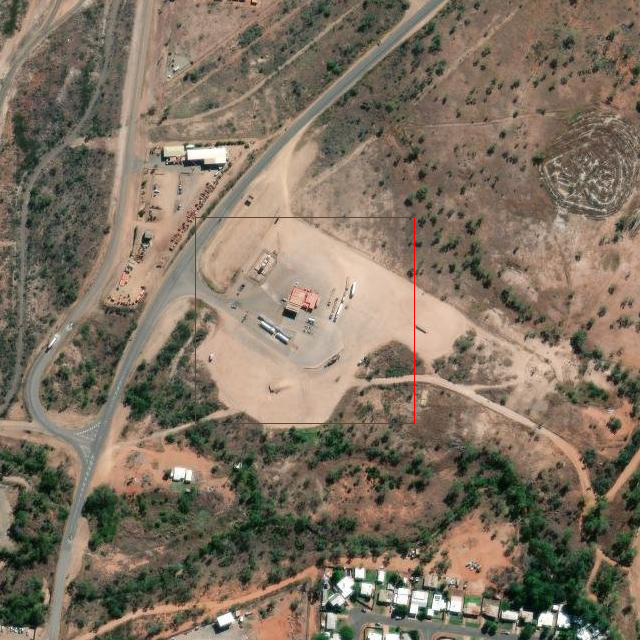

In [36]:
# Checking labels
filenames = os.listdir(DATA_PATH)
filenames = [x[:-5] for x in filenames if x.endswith(".jpeg")]
rnr = random.randrange(0, len(filenames))

idx = filenames[rnr]
#idx = "<<ID>>" # Or specify fielname without extension here
print(idx)

path_jpeg = f"{DATA_PATH}/{idx}.jpeg" #r"C:\Users\Felix\Documents\Code\Trustbit\ndata\train_cars-DELETE\27.4397807_-82.5933404_ts2.jpeg"
path_xml = f"{DATA_PATH}/{idx}.xml"

file = minidom.parse(path_xml)
xmin = int(file.getElementsByTagName('xmin')[0].firstChild.nodeValue)
ymin = int(file.getElementsByTagName('ymin')[0].firstChild.nodeValue)
xmax = int(file.getElementsByTagName('xmax')[0].firstChild.nodeValue)
ymax = int(file.getElementsByTagName('ymax')[0].firstChild.nodeValue)

    
img = Image.open(path_jpeg)
draw = ImageDraw.Draw(img)
draw.rectangle([(xmin,ymin),(xmax,ymax)], outline ="red")
img